# Step 1 - Climate Analysis and Exploration

In [23]:
# Import Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import datetime
import calendar
from sqlalchemy import create_engine, inspect, func
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [24]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import func, text

# Create Engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [25]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [26]:
# First inspect Class & table names
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0xa612668>,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'id': 1}

In [27]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

<strong>Calculate the date 1 year ago from the last data point in the database</strong>

In [28]:
# Query latest date
max_date = engine.execute('''SELECT date FROM measurement ORDER BY date DESC''').first()
# Turn Query into datetime object
max_date_dt = datetime.strptime(max_date[0],'%Y-%m-%d')

# Create function to find year prior to given date (from datetime object to string)
def yr_prior(target_date):
    
    return datetime(year=target_date.year-1, month=target_date.month, day=target_date.day).strftime('%Y-%m-%d')

# Use function to find 1 yr ago from target date, and save into variable name
yr_ago = yr_prior(max_date_dt)

# Turn max date into a string to perform query
max_date_str = max_date_dt.strftime('%Y-%m-%d')

# Perform a query to retrieve the date and precipitation scores, sort by date
results = engine.execute(f'''SELECT date,prcp FROM measurement WHERE date BETWEEN "{yr_ago}" AND "{max_date_str}" ORDER BY date''').fetchall()

# Save the query results as a Pandas DataFrame and set the index to the date column
results_df = pd.DataFrame(results)
results_df.columns = ["Date", "Precipitation"]
results_df = results_df.set_index("Date")

# Drop NAN's
results_df = results_df.dropna()
results_df.head()

Precipitation
Date                     
2016-08-23           0.00
2016-08-23           0.15
2016-08-23           0.05
2016-08-23           0.02
2016-08-23           1.79

<strong> Use Pandas Plotting with Matplotlib to plot the data </strong>

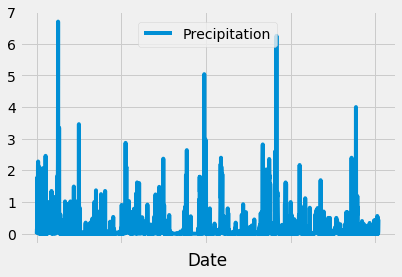

In [29]:
results_df.plot()
plt.legend(loc= 'center', bbox_to_anchor=(.5,.9))

![precipitation](Images/precipitation.png)

<strong> Use Pandas to calcualte the summary statistics for the precipitation data </strong>

In [30]:
results_df.describe()

Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

![describe](Images/describe.png)

<strong> Design a query to show how many stations are available in this dataset </strong>

In [31]:
# Explore the Database by looking at first row of dictionary for Station and Measurement
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0xa6afa90>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [32]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0xa6aff98>,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'id': 1}

In [33]:
# Find number of stations by using "distinct"
num_stations = engine.execute('''SELECT count(distinct station) FROM measurement''')
num_stations.fetchall()

[(9,)]

<strong>What are the most active stations? (i.e. what stations have the most rows)? <br></br>
List the stations and the counts in descending order.</strong>

In [34]:
# Query database to count stations and order by to determine most active in descending order
active_stations = engine.execute('''SELECT station, count(*) AS COUNTS FROM measurement GROUP BY station ORDER BY COUNTS DESC''')
list = active_stations.fetchall()
list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

<strong> Using the station id from the previous query, calculate the lowest temperature recorded, <br></br>
highest temperature recorded, and average temperature of the most active station? </strong>

In [35]:
# Find most active station by indexing the first value of the first tuple from the active stations query
max = list[0][0]

temps = engine.execute(f'''SELECT tobs FROM measurement WHERE station = "{max}" ORDER BY tobs DESC''')
temps = temps.fetchall()
highest = temps[0]
lowest = temps[-1]

sum = 0
for t in temps:
    sum = sum + t[0]
    
avg = sum/len(temps)

<strong>Choose the station with the highest number of temperature observations.</strong>

In [36]:
most_temps = engine.execute('''
SELECT station, count(tobs) AS COUNTS 
FROM measurement 
WHERE tobs IS NOT NULL GROUP BY station 
ORDER BY COUNTS DESC''')
list2 = most_temps.fetchall()
max2 = list2[0][0]

print(max2)

USC00519281


<strong>Query the last 12 months of temperature observation data for this station and plot the results as a histogram</strong>

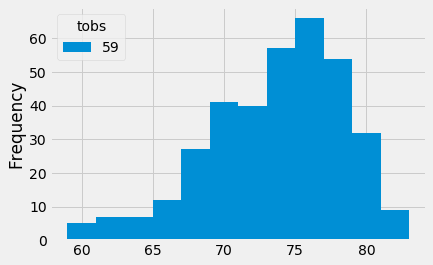

In [37]:
# Query to find the dates of the most active station USC00519281
max_station = engine.execute(f'''SELECT date, tobs FROM measurement WHERE station = "{max2}" ORDER BY date DESC''').fetchall()

# Index & save the most recent tuple 
max_station_latest = max_station[0] # ('2017-08-18', 79.0)

# Index & save the date from the tuple
latest_date = max_station_latest[0] # '2017-08-18'

# Save date as datetime object 
latest_date_dt = datetime.strptime(latest_date,'%Y-%m-%d') # datetime.datetime(2017, 8, 18, 0, 0)

# Use function "yr_prior" created to find & save the date of the last year and datetime into string
station_yr_ago = yr_prior(latest_date_dt) # '2016-08-18'

# Save latest date as a string so it can also be operated on 
latest_date_str = latest_date_dt.strftime('%Y-%m-%d') # '2017-08-18'

# Use the latest date & year ago date to run query and find all temps between the 2 dates and query counts of temps
last_12 = engine.execute(f'''
SELECT tobs, count(tobs) 
FROM measurement 
WHERE station = "{max}" AND date BETWEEN '{station_yr_ago}' AND '{latest_date_str}' 
GROUP BY tobs ''').fetchall()

# From query, save each side of each tuple into lists to be plotted
tobs = []
freq = []

for row in last_12:
    tobs.append(int(row[0]))
    freq.append(int(row[1]))

plt.hist(tobs, bins=12, weights =freq)
plt.ylabel("Frequency")
plt.legend(tobs,title= "tobs")
plt.show()

![precipitation](Images/station-histogram.png)

<strong>This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' <br></br>
and return the minimum, average, and maximum temperatures for that range of dates</strong>

In [38]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


<strong>Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax <br></br>
for your trip using the previous year's data for those same dates.</strong>

In [39]:
prev_yr = calc_temps('2017-06-01', '2017-06-14')
prev_yr

[(72.0, 77.44444444444444, 83.0)]

<strong>Plot the results from your previous query as a bar chart. </strong>

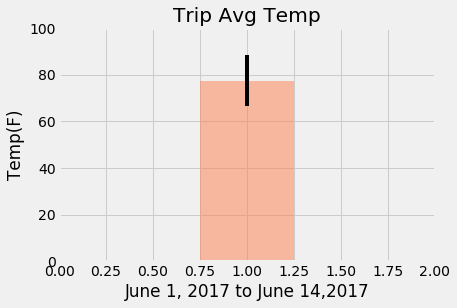

In [40]:
# Use the average temperature for the y value
avg_prev_yr = prev_yr[0][1]

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak = abs((prev_yr[0][0]) - (prev_yr[0][2]))

# Plot Average Temp
# Use "Trip Avg Temp" as your Title
plt.bar(x=1, width = .5,height = avg_prev_yr, bottom=None, yerr=peak, color="coral",alpha=0.5)
plt.ylim(0,100)
plt.xlim(0,2)
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")
plt.xlabel("June 1, 2017 to June 14,2017")
plt.show()

# Step 2 - Climate App

In [41]:
# see app.py

# BONUS Analysis

<strong> Calculate the rainfall per weather station for your trip dates using the previous year's matching dates. <br>
Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation </strong>

In [42]:
weather_stations2 = engine.execute('''
SELECT date, s.station, name, latitude, longitude, elevation
FROM measurement m
INNER JOIN station s ON s.station = m.station
WHERE date BETWEEN '2017-06-01' AND '2017-06-14'
ORDER BY prcp DESC
''').fetchall()
print(weather_stations2)

[('2017-06-04', 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('2017-06-12', 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('2017-06-14', 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('2017-06-11', 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('2017-06-11', 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('2017-06-13', 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), ('2017-06-10', 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), ('2017-06-10', 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('2017-06-13', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('2017-06-12', 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), ('2017-06-14', 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), ('2017-06

In [43]:
results = session.query(Measurement, Station).filter(Measurement.station == Station.station).all()
#return jsonify({})
#print(type(results))

precipitation_list = []


    
#return jsonify(precipitation_list)

In [44]:
for c in results:
    print(c)

(<sqlalchemy.ext.automap.measurement object at 0x000000000A6AF940>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x00000000092B27B8>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x00000000092B2B70>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000A6AF5F8>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000A6AF6A0>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000A6AF908>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000A6AF588>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000A6AF4E0>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000B4A14A8>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B4A1550>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B4A15F8>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B4A16A0>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B4A1748>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B4A17F0>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B4A1898>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B4A1940>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000A366320>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000A366FD0>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B4E3160>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B4E3208>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B4E32B0>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B4E3358>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B4E3400>, <sqlalchemy.ext.automap.station object at 0x000000000A776198>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B4E34A8>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000B5DBA90>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B5DBB38>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B5DBBE0>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B5DBC88>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B5DBD30>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B5DBDD8>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B5DBE80>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B5DBF28>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000B70E550>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B70E5F8>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B70E6A0>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B70E748>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B70E7F0>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B70E898>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B70E940>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B70E9E8>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000B84DF28>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B84DFD0>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B8550B8>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B855160>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B855208>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B8552B0>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B855358>, <sqlalchemy.ext.automap.station object at 0x000000000B55FA90>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B855400>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000B9A4A90>, <sqlalchemy.ext.automap.station object at 0x000000000B8B7940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B9A4B38>, <sqlalchemy.ext.automap.station object at 0x000000000B8B7940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B9A4BE0>, <sqlalchemy.ext.automap.station object at 0x000000000B8B7940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B9A4C88>, <sqlalchemy.ext.automap.station object at 0x000000000B8B7940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B9A4D30>, <sqlalchemy.ext.automap.station object at 0x000000000B8B7940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B9A4DD8>, <sqlalchemy.ext.automap.station object at 0x000000000B8B7940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B9A4E80>, <sqlalchemy.ext.automap.station object at 0x000000000B8B7940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000B9A4F28>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000BAFC4A8>, <sqlalchemy.ext.automap.station object at 0x000000000B8B7940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BAFC550>, <sqlalchemy.ext.automap.station object at 0x000000000B8B7940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BAFC5F8>, <sqlalchemy.ext.automap.station object at 0x000000000B8B7940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BAFC6A0>, <sqlalchemy.ext.automap.station object at 0x000000000B8B7940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BAFC748>, <sqlalchemy.ext.automap.station object at 0x000000000B8B7940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BAFC7F0>, <sqlalchemy.ext.automap.station object at 0x000000000B8B7940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BAFC898>, <sqlalchemy.ext.automap.station object at 0x000000000B8B7940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BAFC940>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000BC4CFD0>, <sqlalchemy.ext.automap.station object at 0x000000000BBA85F8>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BC540B8>, <sqlalchemy.ext.automap.station object at 0x000000000BBA85F8>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BC54160>, <sqlalchemy.ext.automap.station object at 0x000000000BBA85F8>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BC54208>, <sqlalchemy.ext.automap.station object at 0x000000000BBA85F8>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BC542B0>, <sqlalchemy.ext.automap.station object at 0x000000000BBA85F8>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BC54358>, <sqlalchemy.ext.automap.station object at 0x000000000BBA85F8>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BC54400>, <sqlalchemy.ext.automap.station object at 0x000000000BBA85F8>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BC544A8>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000BDA3A90>, <sqlalchemy.ext.automap.station object at 0x000000000BD7A940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BDA3B38>, <sqlalchemy.ext.automap.station object at 0x000000000BD7A940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BDA3BE0>, <sqlalchemy.ext.automap.station object at 0x000000000BD7A940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BDA3C88>, <sqlalchemy.ext.automap.station object at 0x000000000BD7A940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BDA3D30>, <sqlalchemy.ext.automap.station object at 0x000000000BD7A940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BDA3DD8>, <sqlalchemy.ext.automap.station object at 0x000000000BD7A940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BDA3E80>, <sqlalchemy.ext.automap.station object at 0x000000000BD7A940>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BDA3F28>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000BEFB5F8>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BEFB6A0>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BEFB748>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BEFB7F0>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BEFB898>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BEFB940>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BEFB9E8>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000BEFBA90>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000C04BFD0>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C0520B8>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C052160>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C052208>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C0522B0>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C052358>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C052400>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C0524A8>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000C1A3A90>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C1A3B38>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C1A3BE0>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C1A3C88>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C1A3D30>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C1A3DD8>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C1A3E80>, <sqlalchemy.ext.automap.station object at 0x000000000BE26E80>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C1A3F28>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000C2FB550>, <sqlalchemy.ext.automap.station object at 0x000000000C1BB2B0>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C2FB5F8>, <sqlalchemy.ext.automap.station object at 0x000000000C1BB2B0>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C2FB6A0>, <sqlalchemy.ext.automap.station object at 0x000000000C1BB2B0>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C2FB748>, <sqlalchemy.ext.automap.station object at 0x000000000C1BB2B0>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C2FB7F0>, <sqlalchemy.ext.automap.station object at 0x000000000C1BB2B0>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C2FB898>, <sqlalchemy.ext.automap.station object at 0x000000000C1BB2B0>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C2FB940>, <sqlalchemy.ext.automap.station object at 0x000000000C1BB2B0>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C2FB9E8>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000C44AFD0>, <sqlalchemy.ext.automap.station object at 0x000000000C1BB2B0>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C4520B8>, <sqlalchemy.ext.automap.station object at 0x000000000C1BB2B0>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C452160>, <sqlalchemy.ext.automap.station object at 0x000000000C1BB2B0>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C452208>, <sqlalchemy.ext.automap.station object at 0x000000000C1BB2B0>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C4522B0>, <sqlalchemy.ext.automap.station object at 0x000000000C1BB2B0>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C452358>, <sqlalchemy.ext.automap.station object at 0x000000000C1BB2B0>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C452400>, <sqlalchemy.ext.automap.station object at 0x000000000C1BB2B0>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C4524A8>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000C5A2A90>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C5A2B38>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C5A2BE0>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C5A2C88>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C5A2D30>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C5A2DD8>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C5A2E80>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C5A2F28>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000C64E7F0>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C64E898>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C64E940>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C64E9E8>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C64EA90>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C64EB38>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C64EBE0>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C64EC88>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000C7A5208>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C7A52B0>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C7A5358>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C7A5400>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C7A54A8>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C7A5550>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C7A55F8>, <sqlalchemy.ext.automap.station object at 0x000000000C568B38>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000C7A56A0>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000D971A90>, <sqlalchemy.ext.automap.station object at 0x000000000C80F358>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000D971B38>, <sqlalchemy.ext.automap.station object at 0x000000000C80F358>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000D971BE0>, <sqlalchemy.ext.automap.station object at 0x000000000C80F358>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000D971C88>, <sqlalchemy.ext.automap.station object at 0x000000000C80F358>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000D971D30>, <sqlalchemy.ext.automap.station object at 0x000000000C80F358>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000D971DD8>, <sqlalchemy.ext.automap.station object at 0x000000000C80F358>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000D971E80>, <sqlalchemy.ext.automap.station object at 0x000000000C80F358>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000D971F28>, <sqlalchemy.ext

(<sqlalchemy.ext.automap.measurement object at 0x000000000DAC84A8>, <sqlalchemy.ext.automap.station object at 0x000000000C80F358>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000DAC8550>, <sqlalchemy.ext.automap.station object at 0x000000000C80F358>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000DAC85F8>, <sqlalchemy.ext.automap.station object at 0x000000000C80F358>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000DAC86A0>, <sqlalchemy.ext.automap.station object at 0x000000000C80F358>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000DAC8748>, <sqlalchemy.ext.automap.station object at 0x000000000C80F358>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000DAC87F0>, <sqlalchemy.ext.automap.station object at 0x000000000C80F358>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000DAC8898>, <sqlalchemy.ext.automap.station object at 0x000000000C80F358>)
(<sqlalchemy.ext.automap.measurement object at 0x000000000DAC8940>, <sqlalchemy.ext

In [45]:
# """Return a list of precipitation level for date within last 12 months"""
# Query precipitation
weather_stations = engine.execute('''
    select date(m.date), prcp
    from measurement m
    inner join station s on s.station = m.station
    where m.date >= date('2016-08-23')
    order by m.date
''').fetchall()

In [46]:
results2 = session.query(Measurement, Station).filter(Measurement.station == Station.station).limit(10).all()

precip_dict = {}

for r in results2:
    (Measurement, Station) = r
    precip_dict[Measurement.date] = Measurement.prcp

precip_dict

2010-01-01, 0.08
2010-01-02, 0.0
2010-01-03, 0.0
2010-01-04, 0.0
2010-01-06, None
2010-01-07, 0.06
2010-01-08, 0.0
2010-01-09, 0.0
2010-01-10, 0.0
2010-01-11, 0.01


{'2010-01-01': 0.08,
 '2010-01-02': 0.0,
 '2010-01-03': 0.0,
 '2010-01-04': 0.0,
 '2010-01-06': None,
 '2010-01-07': 0.06,
 '2010-01-08': 0.0,
 '2010-01-09': 0.0,
 '2010-01-10': 0.0,
 '2010-01-11': 0.01}

In [40]:
weather_stations

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', None),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.21),
 ('2016-08-25', 0.06),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.03),
 ('2016-08-26', 0.02),
 ('2016-08-26', 0.04),
 ('2016-08-26', 0.0),
 ('2016-08-26', 0.01),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.18),
 ('2016-08-27', 0.02),
 ('2016-08-27', 0.0),
 ('2016-08-27', 0.12),
 ('2016-08-27', None),
 ('2016-08-28', 0.01),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.14),
 ('2016-08-28', 0.6),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.0),
 ('2016-08-29', 0.17),
 ('2016-08-29', 0.04),
 ('2016-08-29', None),
 ('2016-08-29', 0.0),

In [ ]:
# STATION
#  'longitude': -157.8168,
#  'name': 'WAIKIKI 717.2, HI US',
#  'id': 1,
#  'elevation': 3.0,
#  'latitude': 21.2716,
#  'station': 'USC00519397'}

# MEASUREMENT
#  'id': 1,
#  'tobs': 65.0,
#  'date': '2010-01-01',
#  'prcp': 0.08,
#  'station': 'USC00519397'}


In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


tmin       tavg  tmax
date                             
2018-01-01  62.0  69.153846  77.0
2018-01-02  60.0  69.396226  77.0
2018-01-03  62.0  68.909091  77.0
2018-01-04  58.0  70.000000  76.0
2018-01-05  56.0  67.964286  76.0

<IPython.core.display.Javascript object>


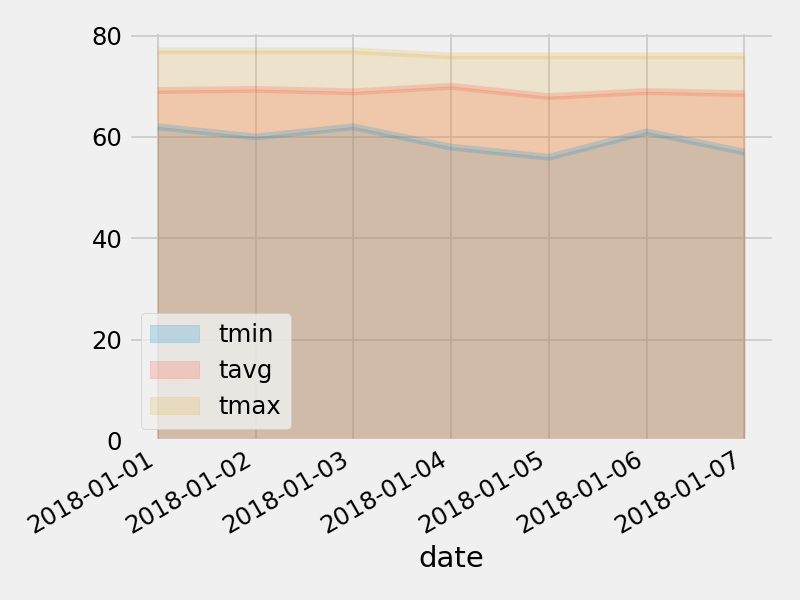

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
